<h1 align="center" style="background-color:DodgerBlue;">Prueba I - Machine Learning </h1>

### Contexto

A continuación se presenta un problema clásico en el análisis de texto: Extraer la polaridad de sentimiento asociado a un texto.
Para esto, utilizaremos una base de datos provenientes de CrowdFlower que se entrega como archivo adjunto para esta prueba bajo el nombre de training_tweets.csv.

El objetivo general de esta prueba es alcanzar el mejor desempeño posible para clasificar si un tweet tiene una polaridad positiva o negativa en cuanto al sentimiento que expresa.

Para poder desarrollar lo solicitado, realizaremos multiples modelos de clasificación. Para ello, se implementan técnicas de minería de texto, procesamiento del lenguaje natural y aprendizaje automático para realizar una análisis de sentimientos en Twitter; utilizando para ello un conjunto de datos almacenados en un csv, el cual contiene dos columnas: Contenido y Sentimiento del mensaje. 

Cabe mencionar que la tarea de clasificación de sentimientos es difícil incluso para los humanos, en donde a veces no posible llegar a un acuerdo respecto a la polaridad del tweet. Además los textos en tweets están sujetos a errores de ortografía, abreviaciones, modismos y humor o sarcasmo. De forma similar al proceso seguido en; utilizamos los siguientes métodos para preprocesar los tweets: Corrección de errores: Para corregir algunos de los errores en el corpus se utilizó un diccionario en inglés, donde se introducen las correcciones ortográficas a los errores más comunes. Además se eliminaron los símbolos extras como “(”, “), ”, “!”, “.”, “:”, “;”, etc.

Se tokeniza el corpus, para generar cada palabra en un elemento único de una lista de datos, posteriormente se lematiza para corregir las singularidades.

In [32]:
# Aspectos computacionales
# Librerias clasicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import func as fx

# Informacion del sistema y datos perdidos
from sinfo import sinfo
import missingno as msngo

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import string

# Machine Learning
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmard\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmard\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dmard\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
# Aspectos computacionales, informacion del sistema y librerias a utilizar con versión
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
func        NA
matplotlib  3.5.2
missingno   0.5.1
nltk        3.7
numpy       1.22.4
pandas      1.4.2
scipy       1.9.3
seaborn     0.11.2
sinfo       0.3.4
sklearn     1.1.3
-----
IPython             8.4.0
jupyter_client      7.3.4
jupyter_core        4.10.0
jupyterlab          3.4.8
notebook            6.5.1
-----
Python 3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]
Windows-10-10.0.22000-SP0
16 logical CPU cores, AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
---

In [34]:
help(fx.vectorize_sentiment)
help(fx.nlp_cleaning)
help(fx.clean_text)

Help on function vectorize_sentiment in module func:

vectorize_sentiment(df, sentimiento='sentiment', objetivo='content', stop_words_='english', plot=False)
    Devuelve una matriz dispersa para analisis de texto.

Help on function nlp_cleaning in module func:

nlp_cleaning(df)
    Devuelve un dataset con el preprocesamiento listo.

Help on function clean_text in module func:

clean_text(df, col_name, new_col_name)
    Funcion que limpia el dataset de caracteres especiales como A-Za-z0-9 etc.



La estrategia de división de muestras será: content como nuestro X y Sentiment como nuestro vector Objetivo Y.

El preprocesamiento será bajo el siguiente orden:
    - Llamar a la función auxiliar clean_text, la cual nos permite limpiar la columna content(corpus) y dejar en una nueva columna content_clean el corpus limpio(sin caracteres especiales).
    - Posteriormente se llama a la función nlp_cleaning, la cual realiza los procesos de reemplazo de StopWords, Tokenización,  Lematatización y posterior unión de los tokens lematizados en la columna content_clean.

Los cinco modelos propuestos de forma preeliminar con hiperparametros tentativos para revisar sus metricas, y posteriormente realizar un trabajo de ajuste de grilla son:

 - MultinomialNB() params = {'alpha': np.linspace(0,20,20)[1:]}
 - RandomForestClassifier() params = {'n_estimators': [50,100,150,200,250,500], 'max_depth':[None, 10,50,70]}
 - LinearSVC() params = {'C': 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma': 'C': [0.00001, 0.0001, 0.001, 0.01, 1, 10]}
 - GaussianNB() params = {var_smoothing : 1e-09}
 - LogisticRegression() params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}

In [35]:
df = pd.read_csv('training_tweets.csv').drop(columns = 'Unnamed: 0', axis = 1)
df.sample(5, random_state = 15820)

content  sentiment
17932            @patrickmanning Yes PM PM you are right  happiness
8768                              @Jae878 aha thanks Jae  happiness
14419  This is my favourite shirt, because its true. ...    neutral
18237  @taylorswift13 ....... i'm wondering if you're...      worry
15206                          @taylor_d No, it's not...    neutral

El vector objetivo sentiment de forma preeliminar presenta la siguiente distribución. Mas abajo se puede apreciar de forma grafica, las palabras con mayor presencia dentro de cada sentimiento.

In [36]:
df['sentiment'].value_counts('%')*100

neutral       21.503333
worry         21.123333
happiness     13.173333
sadness       12.896667
love           9.693333
surprise       5.396667
fun            4.436667
relief         3.860000
hate           3.250000
empty          2.056667
enthusiasm     1.863333
boredom        0.450000
anger          0.296667
Name: sentiment, dtype: float64

<AxesSubplot:title={'center':'Frecuencia de sentimientos'}, xlabel='count', ylabel='sentiment'>

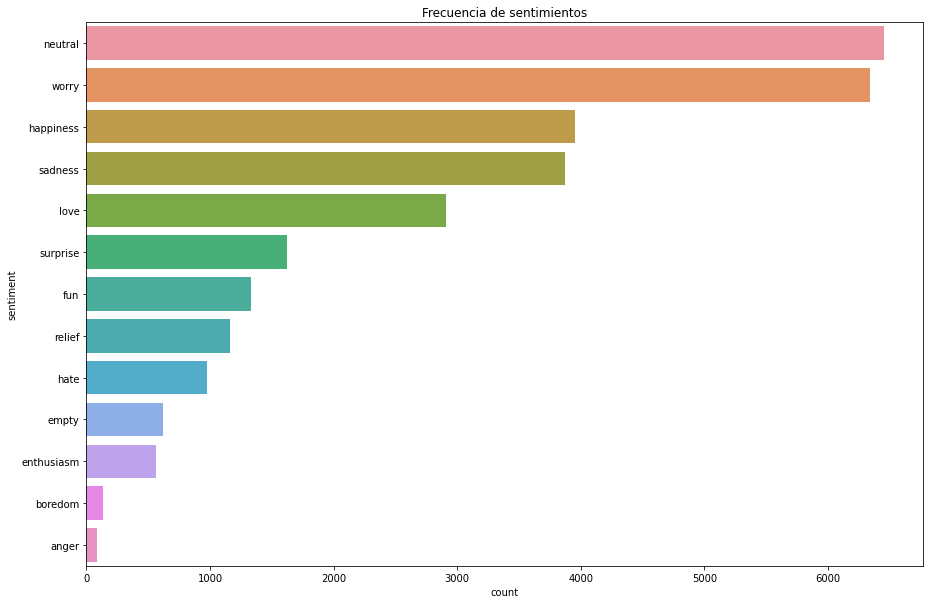

In [37]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 10
plt.title('Frecuencia de sentimientos')
sns.countplot(y= 'sentiment', order = df['sentiment'].value_counts().index, data = df)

In [38]:
print(f'''El dataset contiene {df.shape[0]} filas y {df.shape[1]} columnas''')

El dataset contiene 30000 filas y 2 columnas


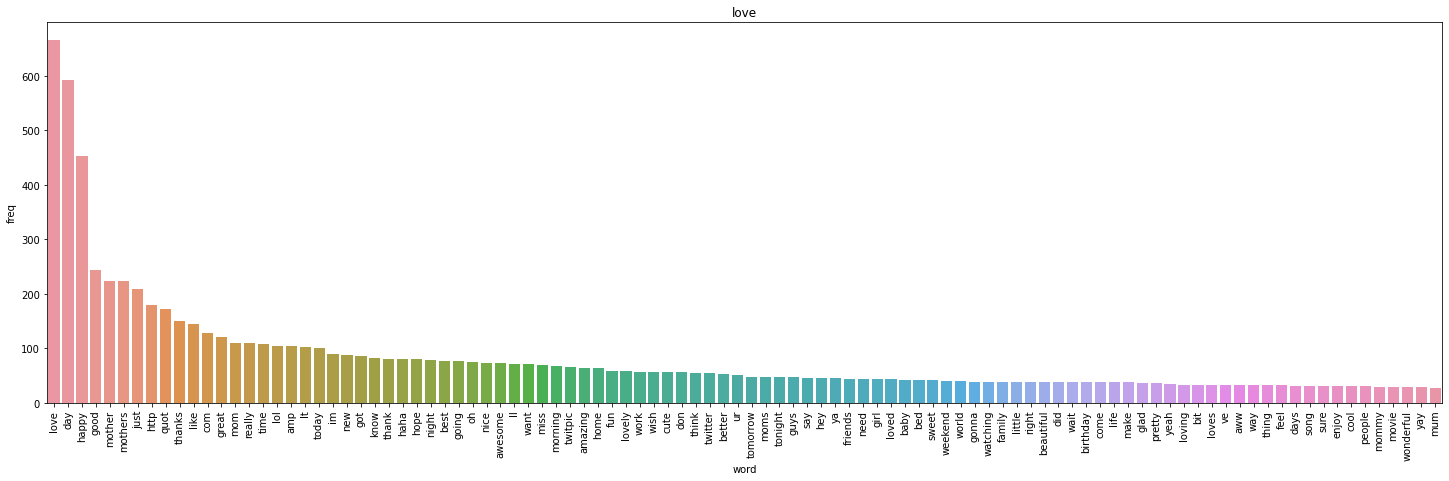

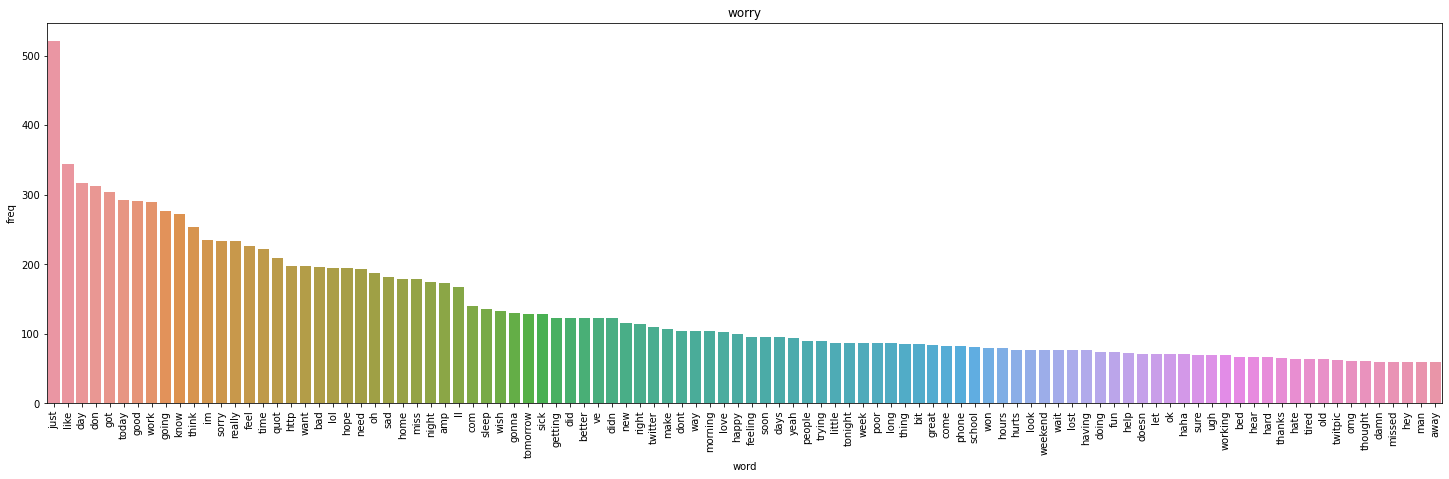

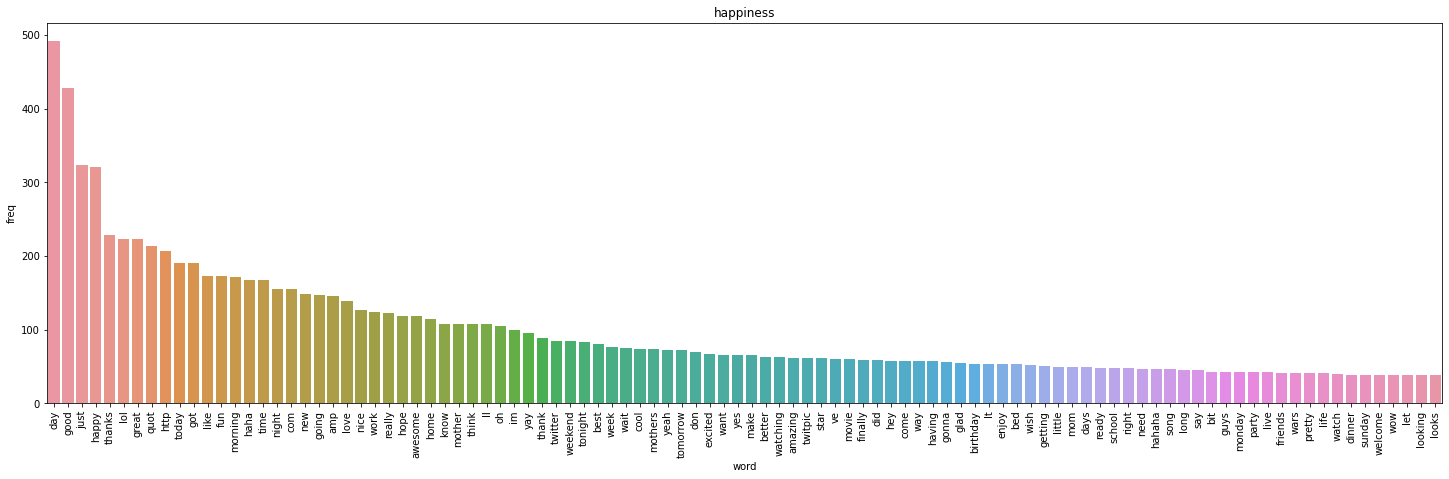

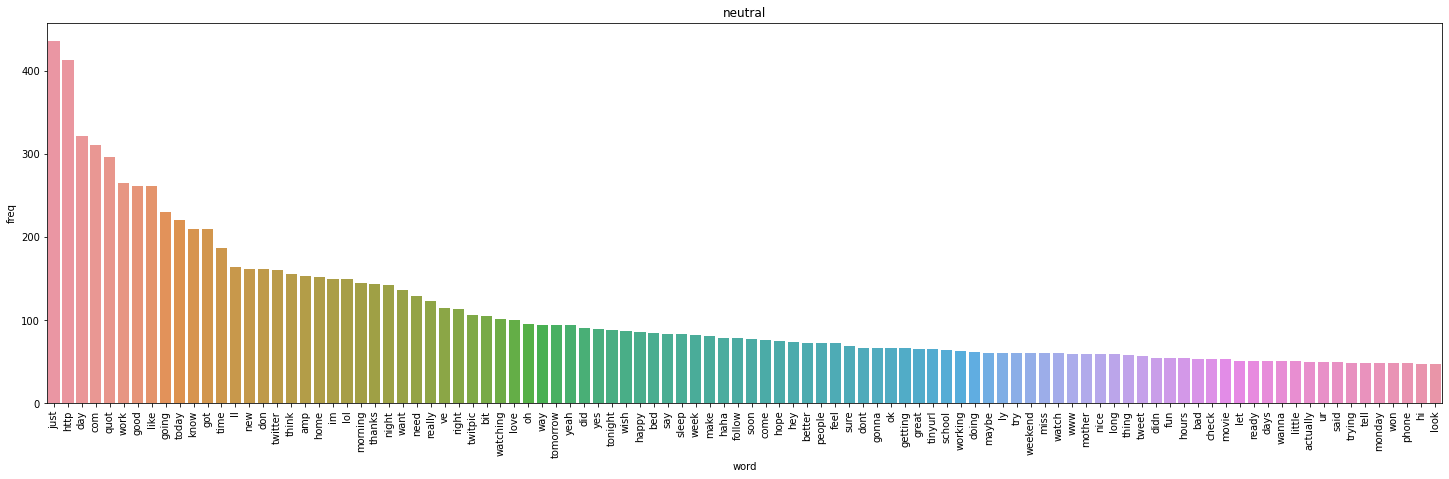

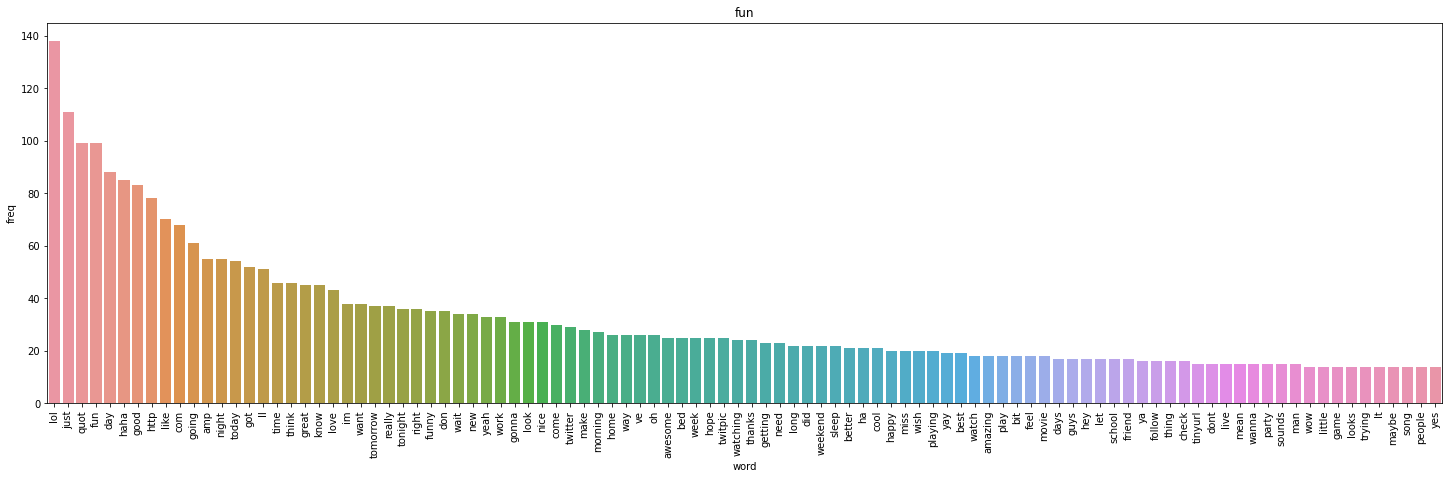

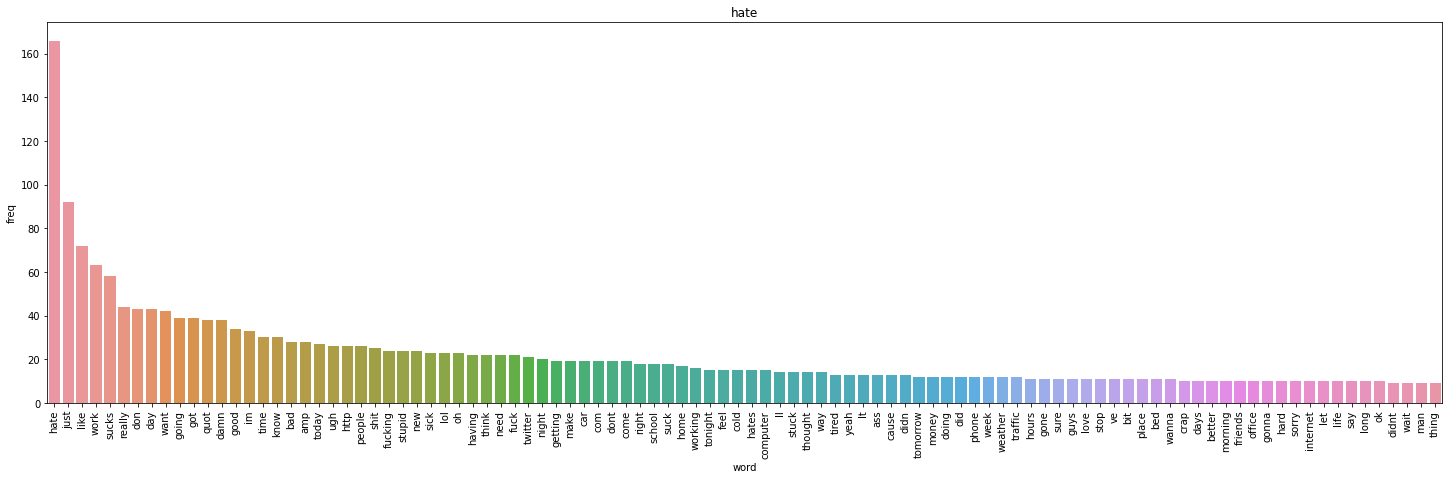

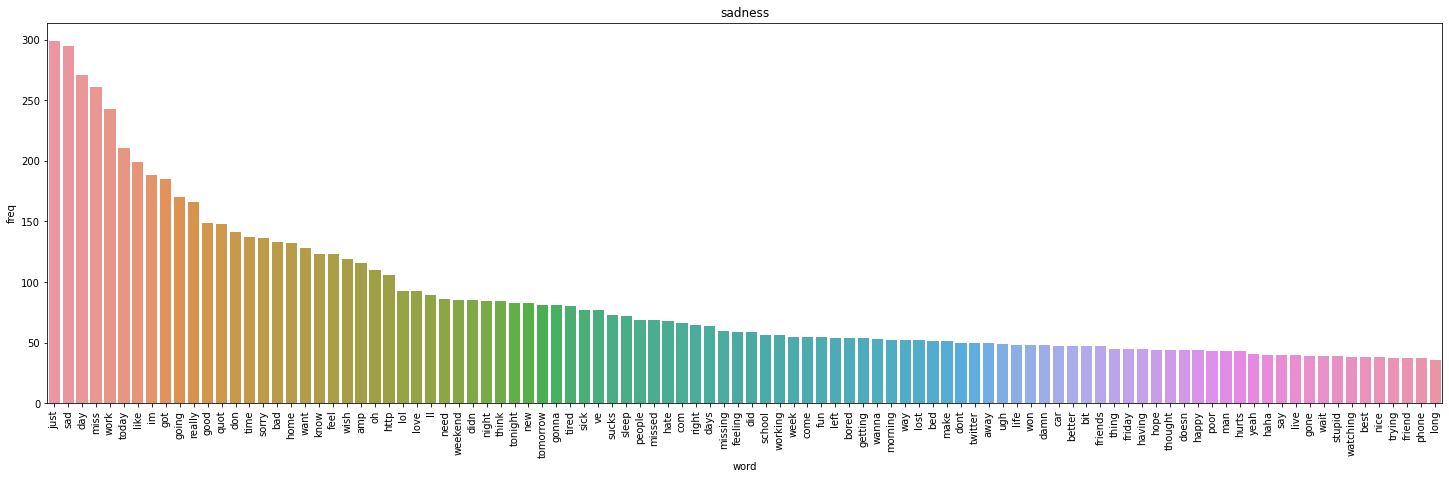

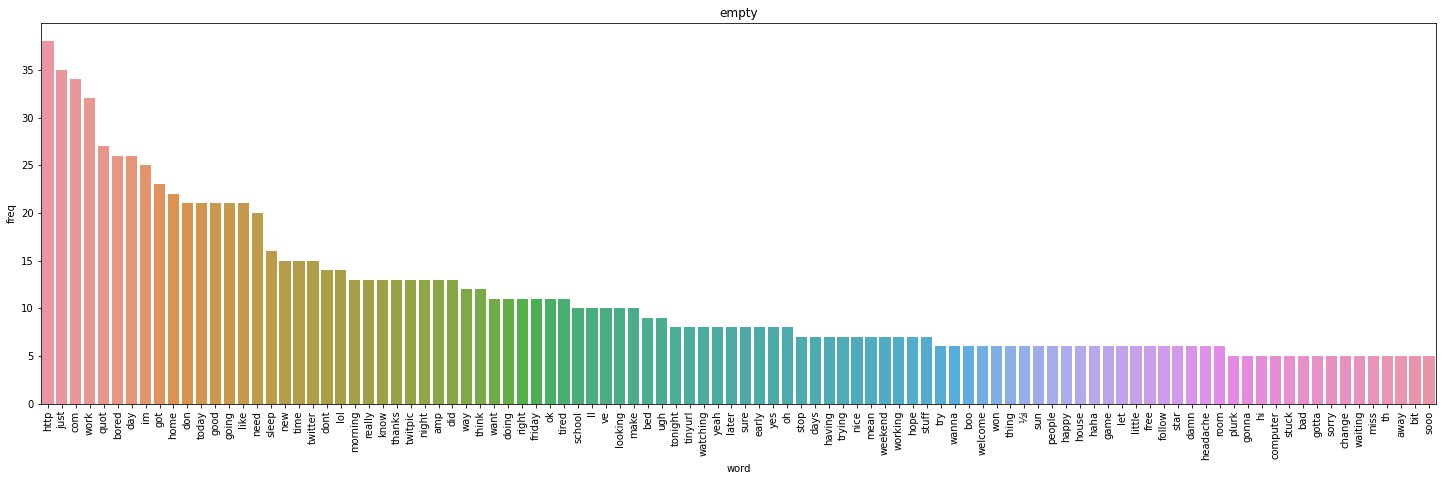

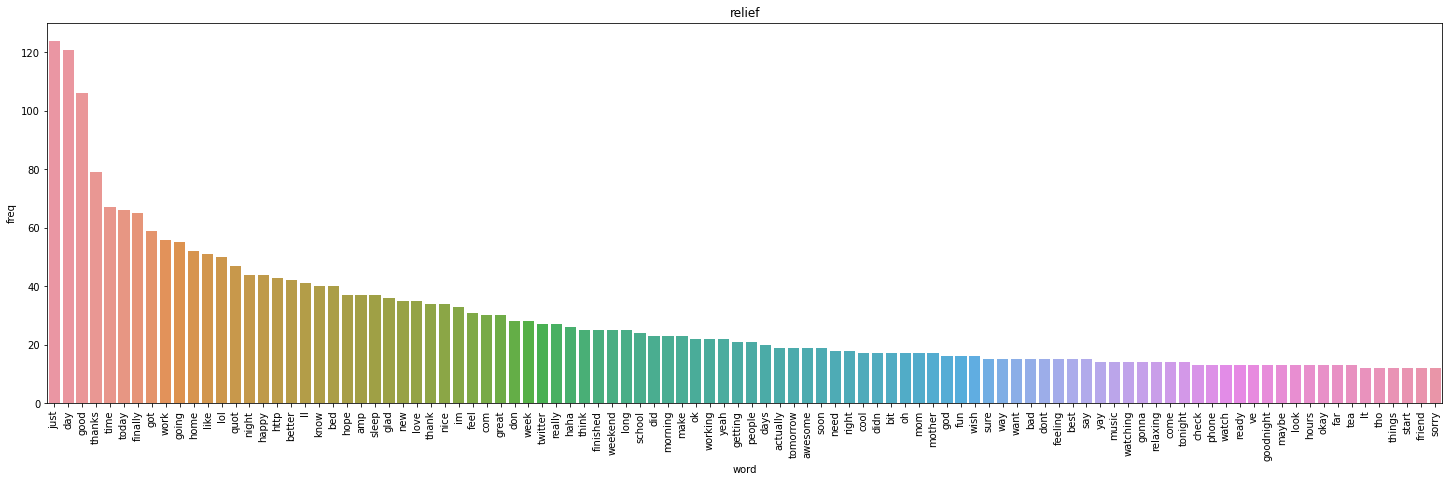

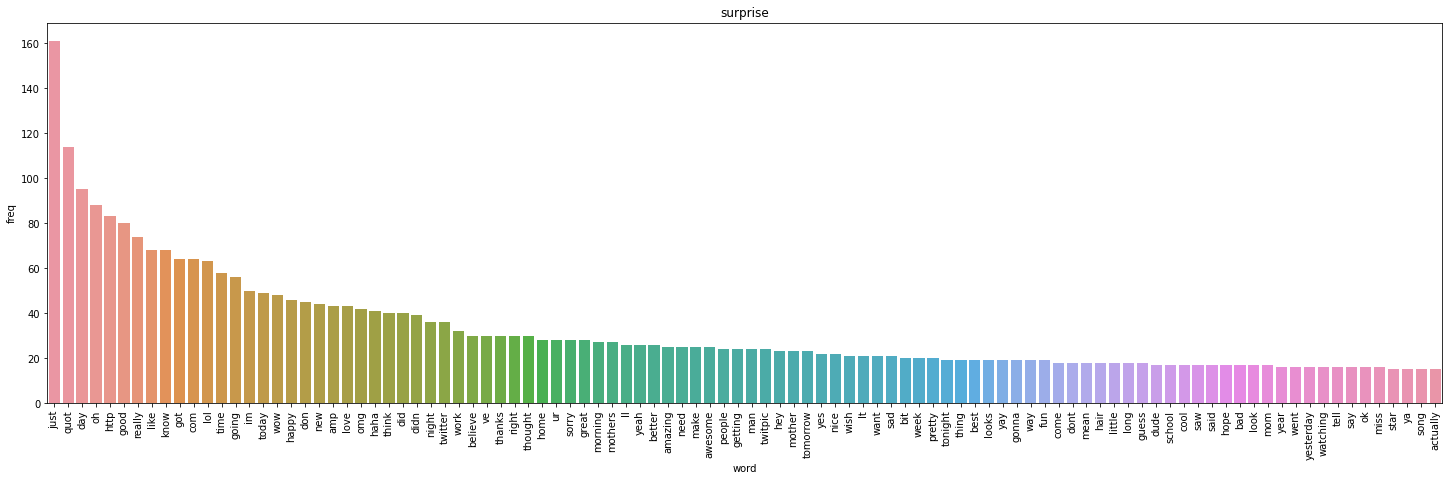

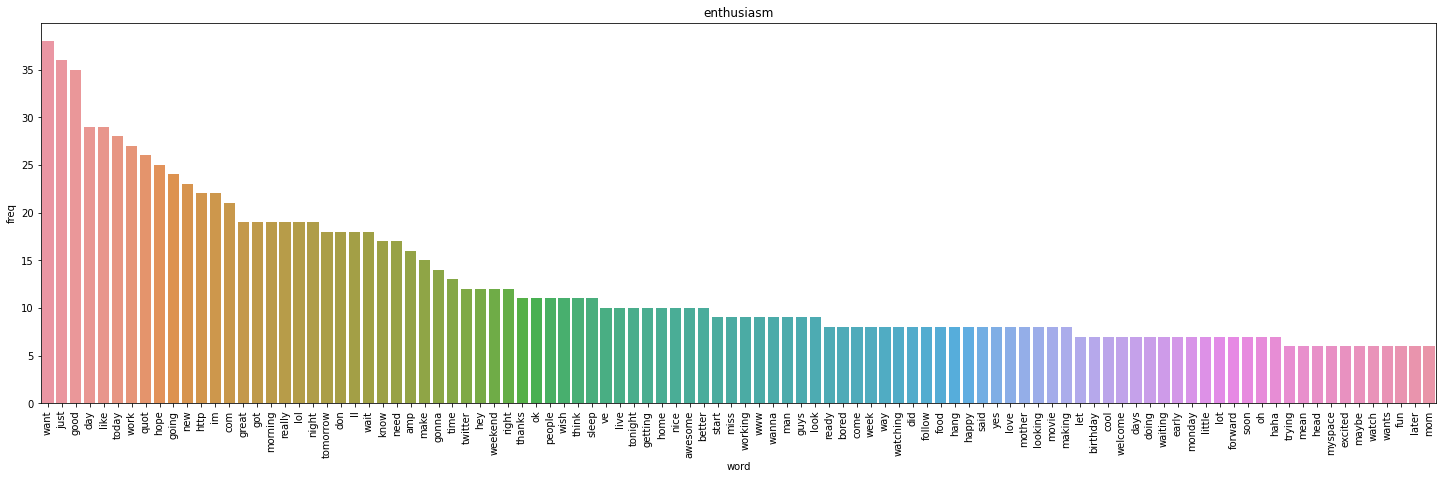

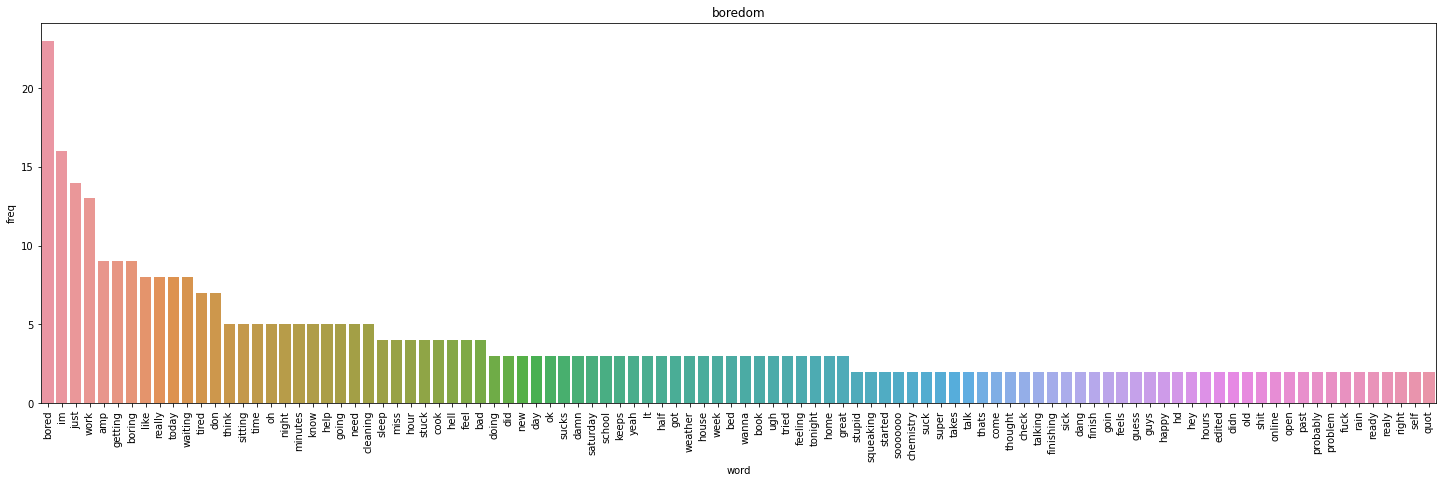

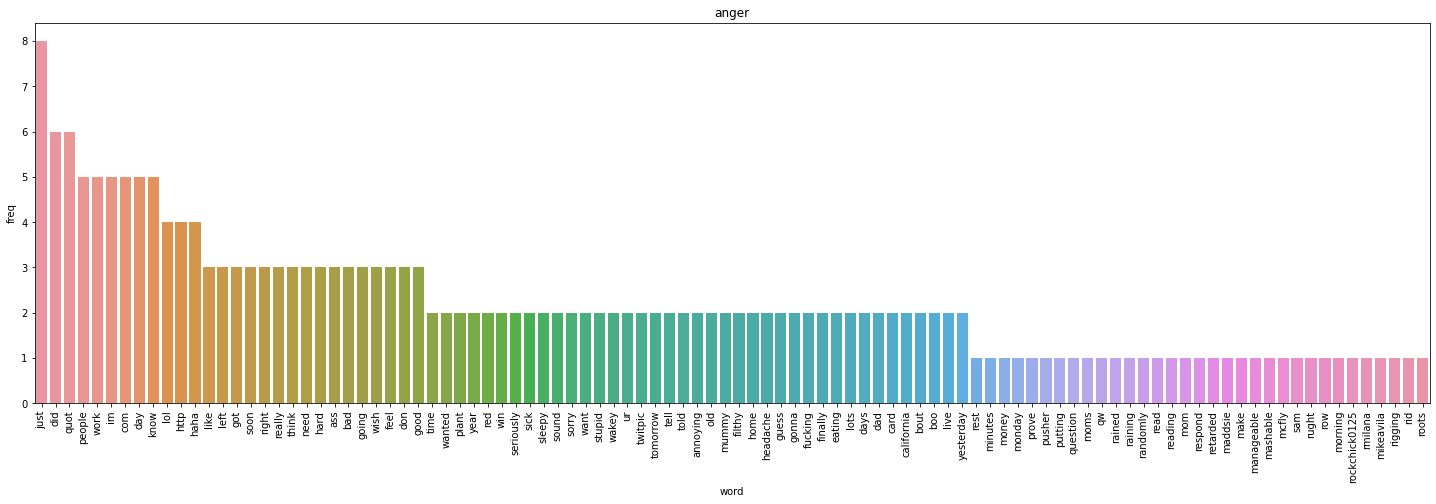

In [39]:
# Frecuecia por sentimientos de las palabras ordenadas de mayor a menor. 
for sentimiento_ in df['sentiment'].unique(): 
    fx.vectorize_sentiment(df, sentimiento = sentimiento_, plot = True)

<AxesSubplot:>

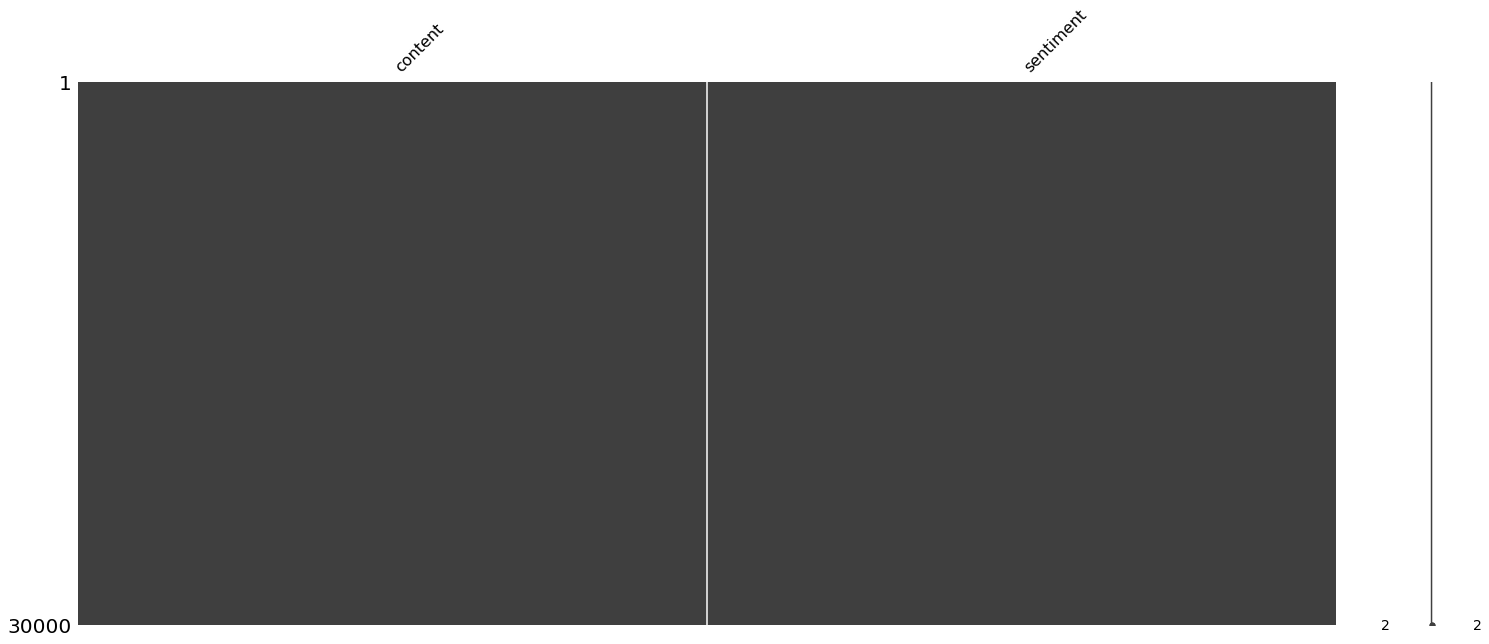

In [40]:
msngo.matrix(df)

El dataset no presenta datos perdidos.

A continuación se implementan las recodificaciones al corpus o contenido del tweet.

In [41]:
fx.clean_text(df, 'content', 'content_clean')

content  sentiment  \
0                        Happy Mama's day to all mothers       love   
1      @LysdelTellez I am lost. Please help me find a...      worry   
2      @BoomKatt yes yes I AM, networking whore to th...  happiness   
3      you@snapplynn Wish that would have been your t...    neutral   
4      now i am doing the MicroEconomics project  iha...      worry   
...                                                  ...        ...   
29995                   I  do not want to work tomorrow!    sadness   
29996  @KandyBee we shuld do  a dance like that its s...        fun   
29997  Photo: Got my prints a few days ago, ready for...  happiness   
29998            @tove_liden Thanks for the follow Tove!        fun   
29999                                 @esmeeworld thanks    neutral   

                                           content_clean  
0                         happy mamas day to all mothers  
1            i am lost. please help me find a good home.  
2       yes yes i am networking whore to the fullest....  
3      you wish that would have been your tweet after...  
4      now i am doing the microeconomics project  iha...  
...                                                  ...  
29995                    i  do not want to work tomorrow  
29996   we shuld do  a dance like that its seriously ...  
29997  photo got my prints a few days ago ready for t...  
29998                   liden thanks for the follow tove  
29999                                             thanks  

[30000 rows x 3 columns]

In [42]:
fx.nlp_cleaning(df)

content  sentiment  \
0                        Happy Mama's day to all mothers       love   
1      @LysdelTellez I am lost. Please help me find a...      worry   
2      @BoomKatt yes yes I AM, networking whore to th...  happiness   
3      you@snapplynn Wish that would have been your t...    neutral   
4      now i am doing the MicroEconomics project  iha...      worry   
...                                                  ...        ...   
29995                   I  do not want to work tomorrow!    sadness   
29996  @KandyBee we shuld do  a dance like that its s...        fun   
29997  Photo: Got my prints a few days ago, ready for...  happiness   
29998            @tove_liden Thanks for the follow Tove!        fun   
29999                                 @esmeeworld thanks    neutral   

                                           content_clean  \
0                           happy mama day to all mother   
1              i am lost please help me find a good home   
2      yes yes i am networking whore to the fullest ....   
3      you wish that would have been your tweet after...   
4      now i am doing the microeconomics project ihat...   
...                                                  ...   
29995                     i do not want to work tomorrow   
29996  we shuld do a dance like that it seriously the...   
29997  photo got my print a few day ago ready for the...   
29998                   liden thanks for the follow tove   
29999                                             thanks   

                                            content_norm  \
0                         happy mamas day to all mothers   
1            i am lost. please help me find a good home.   
2       yes yes i am networking whore to the fullest....   
3      you wish that would have been your tweet after...   
4      now i am doing the microeconomics project  iha...   
...                                                  ...   
29995                    i  do not want to work tomorrow   
29996   we shuld do  a dance like that its seriously ...   
29997  photo got my prints a few days ago ready for t...   
29998                   liden thanks for the follow tove   
29999                                             thanks   

                                       content_norm_stop  \
0                         happy mamas day to all mothers   
1            i am lost. please help me find a good home.   
2      yes yes i am networking whore to the fullest.....   
3      you wish that would have been your tweet after...   
4      now i am doing the microeconomics project ihat...   
...                                                  ...   
29995                     i do not want to work tomorrow   
29996  we shuld do a dance like that its seriously th...   
29997  photo got my prints a few days ago ready for t...   
29998                   liden thanks for the follow tove   
29999                                             thanks   

                                           content_token  \
0                  [happy, mamas, day, to, all, mothers]   
1      [i, am, lost, ., please, help, me, find, a, go...   
2      [yes, yes, i, am, networking, whore, to, the, ...   
3      [you, wish, that, would, have, been, your, twe...   
4      [now, i, am, doing, the, microeconomics, proje...   
...                                                  ...   
29995             [i, do, not, want, to, work, tomorrow]   
29996  [we, shuld, do, a, dance, like, that, its, ser...   
29997  [photo, got, my, prints, a, few, days, ago, re...   
29998            [liden, thanks, for, the, follow, tove]   
29999                                           [thanks]   

                                     content_token_lemma  
0                    [happy, mama, day, to, all, mother]  
1      [i, am, lost, ., please, help, me, find, a, go...  
2      [yes, yes, i, am, networking, whore, to, the, ...  
3      [you, wish, that, would, have, been, your, twe...  
4      [now, i, a

In [43]:
vect = CountVectorizer()
vect_fit = vect.fit_transform(df['content_clean'])

In [44]:
words = vect.get_feature_names()
words_freq = vect_fit.toarray().sum(axis = 0)

In [45]:
df_words = pd.DataFrame(zip(words, words_freq), columns = ['words', 'words_freq'])

df_words.sort_values(by = ['words_freq'], ascending = False)

words  words_freq
23588        to       10741
23204       the        9713
11967        it        6598
15593        my        6005
786         and        5627
...         ...         ...
10952    hostel           1
10948  hospitol           1
10946   hospice           1
10943   hosanna           1
26570   zzzzzzz           1

[26571 rows x 2 columns]

Se establece la recodificación solicitada del vector objetivo, en la cual los sentimientos neutrales, seran reemplazados de forma aleatoria entre Positiva y Negativa.

In [46]:
df['sentiment_code'] = df['sentiment'].replace(['worry'  , 'happiness'  , 'sadness'  , 'love'  , 'surprise'  , 'fun'  , 'relief'  , 'hate'  , 'empty'  , 'enthusiasm'  , 'boredom'  , 'anger'], 
                                    ['Negativa' , 'Positiva' , 'Negativa' , 'Positiva' , 'Positiva' , 'Positiva' , 'Positiva' , 'Negativa' , 'Negativa' , 'Positiva' , 'Negativa' , 'Negativa'])

In [47]:
sentimientos = ['Positiva', 'Negativa']
df['sentiment_code'] = [i.replace('neutral', np.random.choice(sentimientos, 1, p = [0.51, 0.49])[0]) for i in df['sentiment_code']]

In [48]:
df.sample(5, random_state = 15820)

content  sentiment  \
17932            @patrickmanning Yes PM PM you are right  happiness   
8768                              @Jae878 aha thanks Jae  happiness   
14419  This is my favourite shirt, because its true. ...    neutral   
18237  @taylorswift13 ....... i'm wondering if you're...      worry   
15206                          @taylor_d No, it's not...    neutral   

                                           content_clean  \
17932                            yes pm pm you are right   
8768                                      aha thanks jae   
14419  this is my favourite shirt because it true lt ...   
18237       ....... im wondering if youre a awake a i am   
15206                                    d no it not ...   

                                            content_norm  \
17932                            yes pm pm you are right   
8768                                      aha thanks jae   
14419  this is my favourite shirt because its true.  ...   
18237   ....... im wondering if youre as awake as i am.    
15206                                    d no its not...   

                                       content_norm_stop  \
17932                            yes pm pm you are right   
8768                                      aha thanks jae   
14419  this is my favourite shirt because its true. l...   
18237    ....... im wondering if youre as awake as i am.   
15206                                    d no its not...   

                                           content_token  \
17932                     [yes, pm, pm, you, are, right]   
8768                                  [aha, thanks, jae]   
14419  [this, is, my, favourite, shirt, because, its,...   
18237  [......., im, wondering, if, youre, as, awake,...   
15206                             [d, no, its, not, ...]   

                                     content_token_lemma sentiment_code  
17932                     [yes, pm, pm, you, are, right]       Positiva  
8768                                  [aha, thanks, jae]       Positiva  
14419  [this, is, my, favourite, shirt, because, it, ...       Negativa  
18237  [......., im, wondering, if, youre, a, awake, ...       Negativa  
15206                              [d, no, it, not, ...]       Positiva

In [49]:
# Distribucion del vector objetivo recodificado
df['sentiment_code'].value_counts()

Negativa    15153
Positiva    14847
Name: sentiment_code, dtype: int64

<AxesSubplot:xlabel='sentiment_code', ylabel='count'>

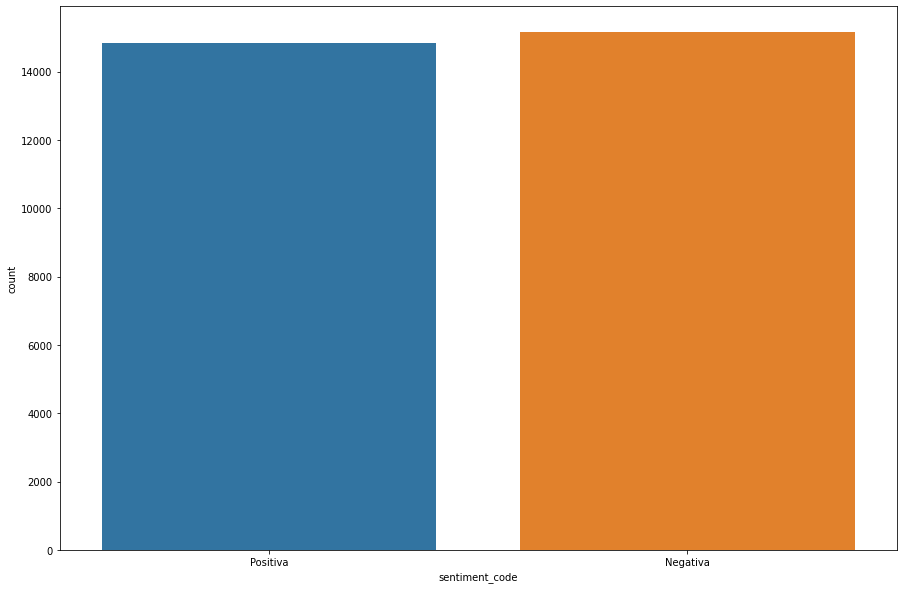

In [50]:
sns.countplot(x = df['sentiment_code'])

In [51]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['content_clean'])
y = df['sentiment_code']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

In [53]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
clf_nb = MultinomialNB().fit(X_train_tfidf, y_train)

In [54]:
y_hat_nb = clf_nb.predict(X_test)
print(classification_report(y_hat_nb, y_test))

              precision    recall  f1-score   support

    Negativa       0.73      0.67      0.70      5511
    Positiva       0.63      0.69      0.66      4389

    accuracy                           0.68      9900
   macro avg       0.68      0.68      0.68      9900
weighted avg       0.69      0.68      0.68      9900



In [55]:
clf_rf = RandomForestClassifier(max_depth = 2, random_state = 15820)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=15820)

In [56]:
y_hat_rf = clf_rf.predict(X_test)
print(classification_report(y_hat_rf, y_test))

              precision    recall  f1-score   support

    Negativa       0.92      0.58      0.71      8028
    Positiva       0.30      0.78      0.43      1872

    accuracy                           0.62      9900
   macro avg       0.61      0.68      0.57      9900
weighted avg       0.80      0.62      0.66      9900



In [57]:
clf_svc = make_pipeline(LinearSVC(random_state = 15820, tol = 1e-5))
clf_svc.fit(X_train, y_train)

Pipeline(steps=[('linearsvc', LinearSVC(random_state=15820, tol=1e-05))])

In [58]:
y_hat_svc = clf_svc.predict(X_test)
print(classification_report(y_hat_svc, y_test))

              precision    recall  f1-score   support

    Negativa       0.64      0.66      0.65      4899
    Positiva       0.65      0.63      0.64      5001

    accuracy                           0.65      9900
   macro avg       0.65      0.65      0.65      9900
weighted avg       0.65      0.65      0.65      9900



In [59]:
gnb = GaussianNB()
model_gnb = gnb.fit(X_train.toarray(), y_train)
model_gnb

GaussianNB()

In [60]:
y_pred_gnb = model_gnb.predict(X_test.toarray())
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

    Negativa       0.53      0.84      0.65      5056
    Positiva       0.56      0.22      0.31      4844

    accuracy                           0.53      9900
   macro avg       0.54      0.53      0.48      9900
weighted avg       0.54      0.53      0.48      9900



In [61]:
clf_lg = LogisticRegression(random_state=15820).fit(X_train, y_train)
clf_lg

LogisticRegression(random_state=15820)

In [62]:
y_hat_lg = clf_lg.predict(X_test)
print(classification_report(y_hat_lg, y_test))

              precision    recall  f1-score   support

    Negativa       0.66      0.68      0.67      4896
    Positiva       0.68      0.66      0.67      5004

    accuracy                           0.67      9900
   macro avg       0.67      0.67      0.67      9900
weighted avg       0.67      0.67      0.67      9900

